<a href="https://colab.research.google.com/github/golki007/BS-MonteCarlo-Derivatives_Pricing/blob/main/Stochastic_Derivative_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

# BLACK SCHOLES

In [ ]:
class BlackScholes:
    def __init__(self, S0, K, r, sigma, T):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T

    def d1(self):
        return (np.log(self.S0 / self.K) +
                (self.r + 0.5 * self.sigma**2) * self.T) / \
               (self.sigma * np.sqrt(self.T))

    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.T)

    def call_price(self):
        d1 = self.d1()
        d2 = self.d2()
        return (self.S0 * norm.cdf(d1) -
                self.K * np.exp(-self.r * self.T) * norm.cdf(d2))


# TEST

In [ ]:
bs = BlackScholes(100, 100, 0.05, 0.2, 1)
print("Black-Scholes Price:", bs.call_price())


Black-Scholes Price: 10.450583572185565


#TIME SERIES VOLATILITY

In [ ]:
"""
class Volatility:
    def __init__(self, omega, alpha, beta, T, steps):
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.steps = steps

    def simulate(self):
        dt = self.T / self.steps
        vol = np.zeros(self.steps)
        vol[0] = np.sqrt(self.omega / (1 - self.alpha - self.beta))

        for t in range(1, self.steps):
            shock = np.random.normal()
            vol[t] = np.sqrt(
                self.omega +
                self.alpha * (shock**2) +
                self.beta * vol[t-1]**2
            )

        return vol

"""

class TimeVaryingVol:
    def __init__(self, sigma0, kappa, theta, vol_of_vol, steps):
        self.sigma0 = sigma0
        self.kappa = kappa
        self.theta = theta
        self.vol_of_vol = vol_of_vol
        self.steps = steps

    def simulate(self):
        sigma = np.zeros(self.steps)
        sigma[0] = self.sigma0

        for t in range(1, self.steps):
            shock = np.random.normal()
            sigma[t] = sigma[t-1] + \
                       self.kappa*(self.theta - sigma[t-1]) + \
                       self.vol_of_vol * shock

        return np.maximum(sigma, 0.05)  # floor to avoid negatives


In [ ]:
vol_model = TimeVaryingVol(
    sigma0=0.2,
    kappa=0.3,
    theta=0.2,
    vol_of_vol=0.02,
    steps=50
)

vol_series = vol_model.simulate()
print("Average Vol:", np.mean(vol_series))


Average Vol: 0.18715701327838016


#MONTE CARLO SIMULATION

In [ ]:
class MonteCarloSimulator:
    def __init__(self, S0, r, vol_series, T, paths):
        self.S0 = S0
        self.r = r
        self.vol_series = vol_series
        self.T = T
        self.paths = paths
        self.steps = len(vol_series)

    def simulate_paths(self):
        dt = self.T / self.steps
        S = np.zeros((self.paths, self.steps + 1))
        S[:, 0] = self.S0

        for t in range(1, self.steps + 1):
            Z = np.random.standard_normal(self.paths)
            sigma_t = self.vol_series[t-1]

            S[:, t] = S[:, t-1] * np.exp(
                (self.r - 0.5 * sigma_t**2) * dt +
                sigma_t * np.sqrt(dt) * Z
            )

        return S


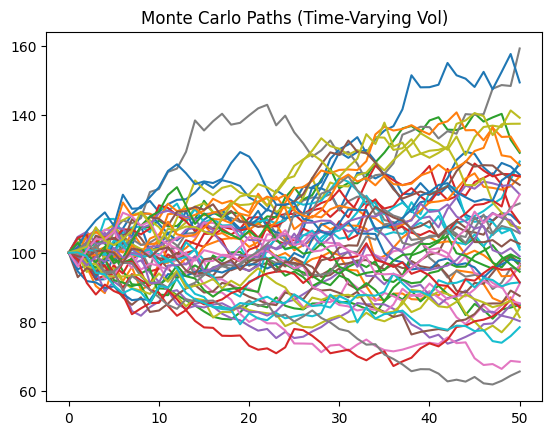

In [ ]:
mc = MonteCarloSimulator(100, 0.05, vol_series, 1, 10000)
paths = mc.simulate_paths()

plt.plot(paths[:50].T)
plt.title("Monte Carlo Paths (Time-Varying Vol)")
plt.show()


#EXPOSURE CALCULATION

In [ ]:
class ExposureCalculator:
    def __init__(self, K):
        self.K = K

    def compute(self, paths):
        return np.maximum(paths - self.K, 0)


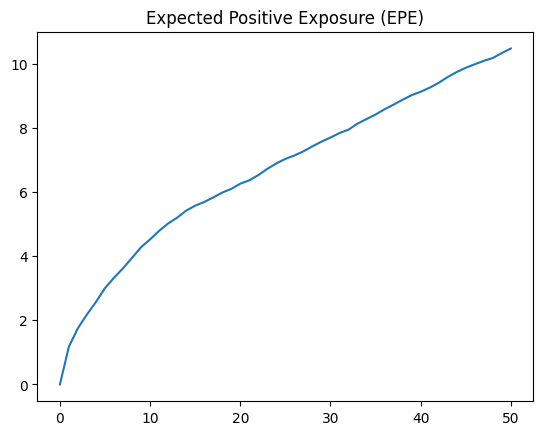

In [ ]:
exposure_calc = ExposureCalculator(100)
exposure = exposure_calc.compute(paths)

EPE = np.mean(exposure, axis=0)

plt.plot(EPE)
plt.title("Expected Positive Exposure (EPE)")
plt.show()


#HAZARD RATE MODEL

In [ ]:
class HazardRateModel:
    def __init__(self, lambda0, alpha, phi, sigma, steps):
        self.lambda0 = lambda0
        self.alpha = alpha
        self.phi = phi
        self.sigma = sigma
        self.steps = steps

    def simulate(self):
        lambdas = np.zeros(self.steps)
        lambdas[0] = self.lambda0

        for t in range(1, self.steps):
            shock = np.random.normal(0, self.sigma)
            lambdas[t] = (
                self.alpha +
                self.phi * lambdas[t-1] +
                shock
            )

        return np.maximum(lambdas, 0)


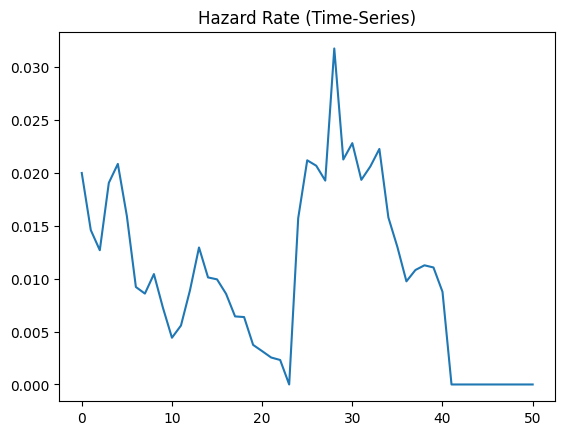

In [ ]:
hazard_model = HazardRateModel(0.02, 0.001, 0.9, 0.005, len(EPE))
lambdas = hazard_model.simulate()

plt.plot(lambdas)
plt.title("Hazard Rate (Time-Series)")
plt.show()


#CVA ENGINE

In [ ]:
class CVAEngine:
    def __init__(self, recovery, r, T):
        self.recovery = recovery
        self.r = r
        self.T = T

    def compute(self, EPE, lambdas):
        steps = len(EPE)
        dt = self.T / steps
        cva = 0

        for t in range(steps):
            pd = 1 - np.exp(-lambdas[t] * dt)
            discount = np.exp(-self.r * t * dt)
            cva += (1 - self.recovery) * EPE[t] * pd * discount

        return cva


In [ ]:
cva_engine = CVAEngine(recovery=0.4, r=0.05, T=1)
cva_value = cva_engine.compute(EPE, lambdas)

print("CVA Value:", cva_value)


CVA Value: 0.03549737270877777


#MONTE CARLO vs BLACK SCHOLES

In [ ]:
mc_price = np.mean(np.maximum(paths[:, -1] - 100, 0)) * np.exp(-0.05 * 1)

print("Monte Carlo Price:", mc_price)
print("Black-Scholes Price:", bs.call_price())


Monte Carlo Price: 9.961596806085575
Black-Scholes Price: 10.450583572185565


In [ ]:
print("Average Volatility:", np.mean(vol_series))


Average Volatility: 0.18715701327838016
